In [1]:
pip install yfinance hmmlearn matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from datetime import datetime, timedelta

In [3]:
TICKER = "AAPL"          # you can change to TSLA, ^GSPC, etc.
N_YEARS = 10             # how many years of data
N_STATES = 2             # number of hidden regimes (2 = low/high volatility)
START_DATE = (datetime.today() - timedelta(days=365 * N_YEARS)).strftime("%Y-%m-%d")
END_DATE = datetime.today().strftime("%Y-%m-%d")

In [12]:
def download_price_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """
    Download historical price data from Yahoo Finance.
    Uses Adjusted Close to account for splits/dividends.
    """
    df = yf.download(ticker, start=start, end=end, auto_adjust=True) # Explicitly set auto_adjust to True
    if df.empty:
        raise ValueError(f"No data downloaded for {ticker}. Check ticker or date range.")
    df = df[['Close']].rename(columns={'Close': 'Adj_Close'}) # Use 'Close' column
    df.dropna(inplace=True)
    return df


def compute_daily_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute daily log returns from adjusted closing prices.
    """
    df = df.copy()
    df["Return"] = np.log(df["Adj_Close"] / df["Adj_Close"].shift(1))
    df.dropna(inplace=True)
    return df

In [5]:
def fit_gaussian_hmm(returns: np.ndarray, n_states: int = 2, n_iter: int = 1000) -> GaussianHMM:
    """
    Fit a Gaussian Hidden Markov Model to 1D returns.
    returns: 1D numpy array of returns
    """
    # hmmlearn expects 2D array: shape (n_samples, n_features)
    X = returns.reshape(-1, 1)

    model = GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=n_iter,
        random_state=42
    )
    model.fit(X)
    return model


def analyze_states(model: GaussianHMM) -> pd.DataFrame:
    """
    Return a DataFrame summarizing mean and variance of each hidden state.
    """
    means = model.means_.flatten()
    variances = np.array([np.diag(cov)[0] for cov in model.covars_])
    stds = np.sqrt(variances)
    state_ids = np.arange(model.n_components)

    df_states = pd.DataFrame({
        "State": state_ids,
        "Mean_Return": means,
        "Volatility(Std)": stds,
        "Variance": variances
    }).sort_values("Mean_Return").reset_index(drop=True)

    return df_states

In [6]:
def decode_hidden_states(model: GaussianHMM, returns: np.ndarray) -> np.ndarray:
    """
    Use Viterbi algorithm to find the most likely hidden state sequence.
    """
    X = returns.reshape(-1, 1)
    hidden_states = model.predict(X)
    return hidden_states


def get_transition_matrix(model: GaussianHMM) -> pd.DataFrame:
    """
    Return transition matrix as a pandas DataFrame.
    """
    trans_mat = model.transmat_
    n_states = model.n_components
    return pd.DataFrame(
        trans_mat,
        columns=[f"To_State_{j}" for j in range(n_states)],
        index=[f"From_State_{i}" for i in range(n_states)]
    )

In [7]:
def plot_regimes_price(df: pd.DataFrame, hidden_states: np.ndarray, title_suffix: str = ""):
    """
    Plot adjusted close price with regime color-coding based on hidden states.
    """
    plt.figure(figsize=(14, 6))
    unique_states = np.unique(hidden_states)
    for state in unique_states:
        mask = hidden_states == state
        plt.plot(df.index[mask], df["Adj_Close"][mask], linestyle='-', marker='.', label=f"State {state}")

    plt.title(f"{title_suffix} Price with Hidden Markov Regimes")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_regimes_returns(df: pd.DataFrame, hidden_states: np.ndarray, title_suffix: str = ""):
    """
    Plot daily returns with regime color-coding based on hidden states.
    """
    plt.figure(figsize=(14, 6))
    unique_states = np.unique(hidden_states)
    for state in unique_states:
        mask = hidden_states == state
        plt.scatter(df.index[mask], df["Return"][mask], s=10, label=f"State {state}", alpha=0.7)

    plt.axhline(0, linestyle='--')
    plt.title(f"{title_suffix} Returns with Hidden Markov Regimes")
    plt.xlabel("Date")
    plt.ylabel("Daily Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
def predict_next_state(model: GaussianHMM, latest_state: int) -> int:
    """
    Predict the most likely next hidden state given the latest hidden state
    using the transition matrix.
    """
    trans_mat = model.transmat_
    next_state_probs = trans_mat[latest_state]
    next_state = int(np.argmax(next_state_probs))
    return next_state

In [10]:
def regime_labeling(df_states: pd.DataFrame) -> dict:
    """
    Label states as 'Low Volatility / Bull-ish' or 'High Volatility / Bear-ish' etc.
    This is heuristic based on mean and volatility.
    """
    # Sort by volatility and mean for simple labels
    # Lower volatility and higher mean -> more 'bull' like
    sorted_states = df_states.sort_values(
        ["Volatility(Std)", "Mean_Return"],
        ascending=[True, False]
    ).reset_index(drop=True)

    labels = {}
    for i, row in sorted_states.iterrows():
        state = int(row["State"])
        if i == 0:
            labels[state] = "Low Vol / Higher Mean (Bull-like)"
        elif i == len(sorted_states) - 1:
            labels[state] = "High Vol / Lower Mean (Bear-like)"
        else:
            labels[state] = "Intermediate Regime"

    return labels

[*********************100%***********************]  1 of 1 completed


First few rows of preprocessed data:
Price       Adj_Close    Return
Ticker           AAPL          
Date                           
2015-11-27  26.562494 -0.001866
2015-11-30  26.672976  0.004151
2015-12-01  26.456524 -0.008148
2015-12-02  26.217529 -0.009075
2015-12-03  25.974030 -0.009331

Fitting Gaussian HMM with 2 hidden states...

State parameter summary (means and volatilities):
   State  Mean_Return  Volatility(Std)  Variance
0      1    -0.000927         0.031190  0.000973
1      0     0.001508         0.012006  0.000144

Heuristic labels for states:
State 0: Low Vol / Higher Mean (Bull-like)
State 1: High Vol / Lower Mean (Bear-like)

Transition matrix:
              To_State_0  To_State_1
From_State_0    0.959293    0.040707
From_State_1    0.128956    0.871044


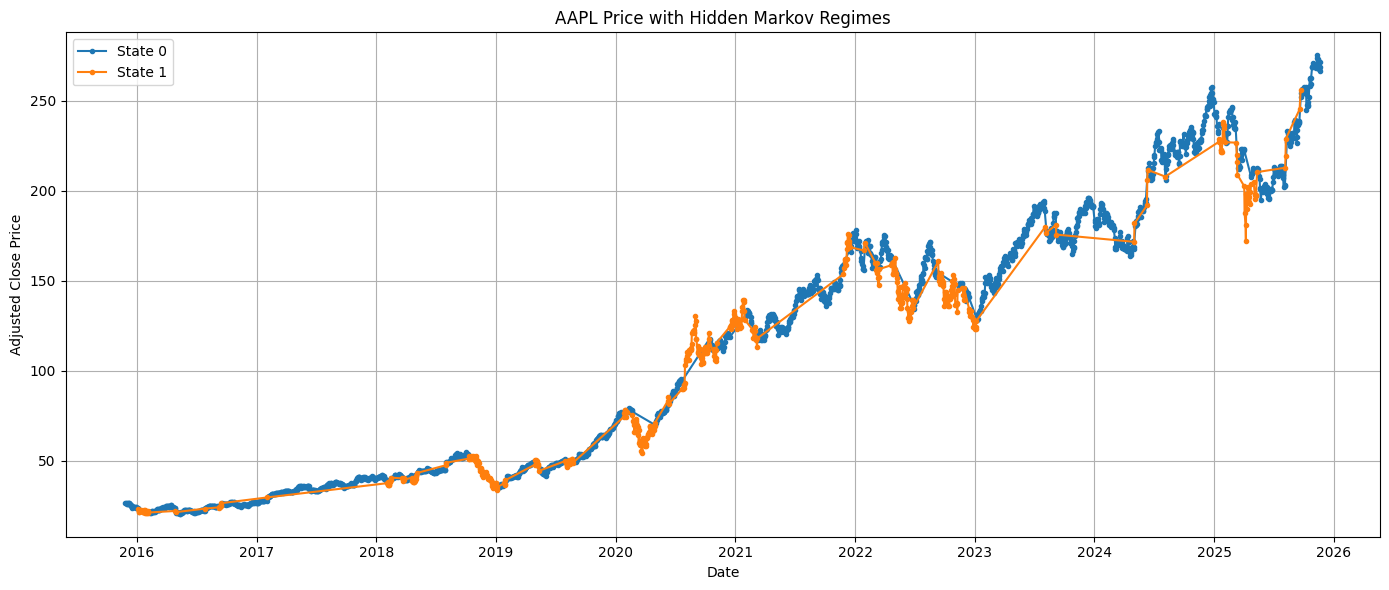

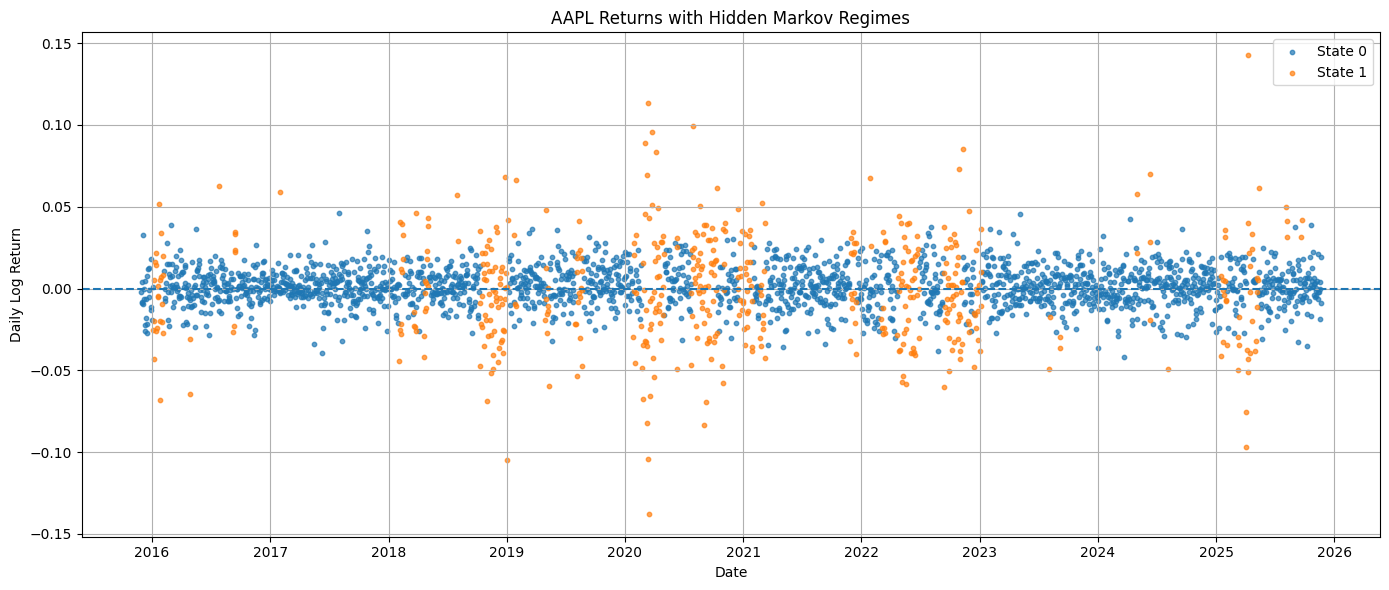


Basic interpretation:
State 1: Mean return = -0.00093, Volatility (std) = 0.03119 
State 0: Mean return = 0.00151, Volatility (std) = 0.01201 

Number of days in each state:
State
0    2006
1     506
Name: count, dtype: int64

Most recent hidden state: State 0 (Low Vol / Higher Mean (Bull-like))
Transition probabilities from this state:
  -> State 0: 0.959
  -> State 1: 0.041

Most likely next hidden state: State 0 (Low Vol / Higher Mean (Bull-like))

You can interpret this as the most likely short-term market regime based on the estimated transition dynamics.


In [15]:
def main():
    print(f"Downloading {N_YEARS} years of data for {TICKER} from Yahoo Finance...")
    df_prices = download_price_data(TICKER, START_DATE, END_DATE)
    df = compute_daily_returns(df_prices)

    print("\nFirst few rows of preprocessed data:")
    print(df.head())

    # Fit HMM
    print(f"\nFitting Gaussian HMM with {N_STATES} hidden states...")
    returns = df["Return"].values
    model = fit_gaussian_hmm(returns, n_states=N_STATES)

    # Analyze states
    df_states = analyze_states(model)
    print("\nState parameter summary (means and volatilities):")
    print(df_states)

    # Label regimes
    labels = regime_labeling(df_states)
    print("\nHeuristic labels for states:")
    for state, label in labels.items():
        print(f"State {state}: {label}")

    # Decode hidden states
    hidden_states = decode_hidden_states(model, returns)
    df["State"] = hidden_states

    # Transition matrix
    print("\nTransition matrix:")
    trans_df = get_transition_matrix(model)
    print(trans_df)

    # Visualizations
    plot_regimes_price(df, hidden_states, title_suffix=f"{TICKER}")
    plot_regimes_returns(df, hidden_states, title_suffix=f"{TICKER}")

    # Simple "evaluation" / discussion-style outputs
    print("\nBasic interpretation:")
    for _, row in df_states.iterrows():
        s = int(row["State"])
        print(
            f"State {s}: Mean return = {row['Mean_Return']:.5f}, "
            f"Volatility (std) = {row['Volatility(Std)']:.5f} "
        )

    # Count how many days in each state
    state_counts = df["State"].value_counts().sort_index()
    print("\nNumber of days in each state:")
    print(state_counts)

    # Predict likely future state
    latest_state = int(hidden_states[-1])
    next_state = predict_next_state(model, latest_state)
    next_state_prob_vec = model.transmat_[latest_state]

    print(f"\nMost recent hidden state: State {latest_state} ({labels.get(latest_state, 'Unknown')})")
    print("Transition probabilities from this state:")
    for s in range(model.n_components):
        print(f"  -> State {s}: {next_state_prob_vec[s]:.3f}")
    print(
        f"\nMost likely next hidden state: State {next_state} "
        f"({labels.get(next_state, 'Unknown')})"
    )
    print("\nYou can interpret this as the most likely short-term market regime "
          "based on the estimated transition dynamics.")


if __name__ == "__main__":
    main()